# Метрики

## Imports

In [ ]:
import pandas as pd
import numpy as np
import numba as nb

from tqdm.auto import tqdm
from rectools import Columns

In [ ]:
np.random.seed(23)

## Read data

In [ ]:
interactions = pd.read_csv('data_original/interactions.csv')

interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])

In [ ]:
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

In [ ]:
def headtail(df):
    return pd.concat([df.head(), df.tail()])

headtail(interactions)

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [ ]:
interactions.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      int64         
 1   item_id      int64         
 2   datetime     datetime64[ns]
 3   weight       int64         
 4   watched_pct  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 208.9 MB


Выделим небольшой кусок из данных, чтобы не слишком страдать

In [ ]:
sample_users = [57607, 403227, 70720]
df = interactions[interactions[Columns.User].isin(sample_users)].reset_index(drop=True)
del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
df

,user_id,item_id
0,70720,4880
1,57607,4151
2,57607,10440
3,70720,4881
4,403227,6353
5,403227,1736
6,70720,6327
7,57607,13865
8,403227,5336
9,403227,181


In [ ]:
print('Users', df[Columns.User].unique())
sample_items = df[Columns.Item].unique()
print('Items', sample_items)

Users [ 70720  57607 403227]
Items [ 4880  4151 10440  4881  6353  1736  6327 13865  5336   181]


## Regression

В регрессией все относительно просто. По (user, item) мы знаем таргет (рейтинг чаще всего) и по такой же паре предсказываем его

In [ ]:
df['target'] = np.random.choice([3, 4, 5], df.shape[0])
df['predict'] = np.random.rand(df.shape[0]) * 3 + 2
df

,user_id,item_id,target,predict
0,70720,4880,5,2.658958
1,57607,4151,3,4.500017
2,57607,10440,4,3.280296
3,70720,4881,5,4.263719
4,403227,6353,3,4.990597
5,403227,1736,4,2.000249
6,70720,6327,3,4.927865
7,57607,13865,5,3.257364
8,403227,5336,4,4.044672
9,403227,181,5,4.257889


Общая оценка

In [ ]:
mae = (df['target'] - df['predict']).abs().mean()
print(mae)

1.374467645324227


Оценка по пользователю с последюущим усреднением

In [ ]:
df['diff'] = (df['target'] - df['predict']).abs()
average_mae = df.groupby(Columns.User)['diff'].mean()
print(average_mae.mean())
average_mae

1.3944881931989215


user_id
57607     1.320786
70720     1.668396
403227    1.194283
Name: diff, dtype: float64

Видно, что в данном случае метрики близки к друг другу, но это не всегда так

In [ ]:
del df['target'], df['predict'], df['diff']

## Classification

Сгенерируем случайные рекомендации.

In [ ]:
top_k = 5
recs = np.array([
    np.random.choice(sample_items, top_k, replace=False),
    np.random.choice(sample_items, top_k, replace=False),
    np.random.choice(sample_items, top_k, replace=False),
])
recs

array([[ 4880,  6327, 10440,  1736,  4881],
       [  181,  1736,  4880, 13865,  6353],
       [ 4151,  4881,  6353, 10440,  1736]], dtype=int64)

Преобразуем в длинный датафрейм

In [ ]:
df_recs = pd.DataFrame({
    Columns.User: np.repeat(sample_users, top_k),
    Columns.Item: recs.ravel()
})
df_recs

,user_id,item_id
0,57607,4880
1,57607,6327
2,57607,10440
3,57607,1736
4,57607,4881
5,403227,181
6,403227,1736
7,403227,4880
8,403227,13865
9,403227,6353


In [ ]:
df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1
headtail(df_recs)

,user_id,item_id,rank
0,57607,4880,1
1,57607,6327,2
2,57607,10440,3
3,57607,1736,4
4,57607,4881,5
10,70720,4151,1
11,70720,4881,2
12,70720,6353,3
13,70720,10440,4
14,70720,1736,5


Ключевой момент. Именно ради него преобразовывали данные и именно это позволяет считать метрики быстрее.

In [ ]:
df_recs = df.merge(df_recs, how='left', left_on=Columns.UserItem, right_on=Columns.UserItem)
df_recs = df_recs.sort_values(by=[Columns.User, Columns.Rank])
df_recs

,user_id,item_id,rank
2,57607,10440,3.0
1,57607,4151,NaN
7,57607,13865,NaN
3,70720,4881,2.0
0,70720,4880,NaN
6,70720,6327,NaN
9,403227,181,1.0
5,403227,1736,2.0
4,403227,6353,5.0
8,403227,5336,NaN


### Precision@K

In [ ]:
df_recs[f'TP@5'] = df_recs['rank'] < 6
df_recs

,user_id,item_id,rank,TP@5
2,57607,10440,3.0,True
1,57607,4151,NaN,False
7,57607,13865,NaN,False
3,70720,4881,2.0,True
0,70720,4880,NaN,False
6,70720,6327,NaN,False
9,403227,181,1.0,True
5,403227,1736,2.0,True
4,403227,6353,5.0,True
8,403227,5336,NaN,False


In [ ]:
df_recs[df_recs[Columns.Rank].notnull()]

,user_id,item_id,rank,TP@5
2,57607,10440,3.0,True
3,70720,4881,2.0,True
9,403227,181,1.0,True
5,403227,1736,2.0,True
4,403227,6353,5.0,True


Посчитаем вручную (1/5 + 1/5 + 3/5) / 3

In [ ]:
df_recs['TP@5/5'] = df_recs['TP@5'] / top_k 

p5 = df_recs.groupby(Columns.User)['TP@5/5'].sum().mean()

print(f'Precision@5 = {p5}')

Precision@5 = 0.3333333333333333


In [ ]:
df_recs

,user_id,item_id,rank,TP@5,TP@5/5
2,57607,10440,3.0,True,0.2
1,57607,4151,NaN,False,0.0
7,57607,13865,NaN,False,0.0
3,70720,4881,2.0,True,0.2
0,70720,4880,NaN,False,0.0
6,70720,6327,NaN,False,0.0
9,403227,181,1.0,True,0.2
5,403227,1736,2.0,True,0.2
4,403227,6353,5.0,True,0.2
8,403227,5336,NaN,False,0.0


Используем тот факт, что мы знаем количество пользователей, а значит groupby не нужен

In [ ]:
p5 = df_recs['TP@5/5'].sum() / len(sample_users)
print(f'Precision@5 = {p5}')

Precision@5 = 0.3333333333333333


### Recall@K

In [ ]:
df_recs['actual'] = df_recs.groupby(Columns.User)[Columns.Item].transform('count')
df_recs

,user_id,item_id,rank,TP@5,TP@5/5,actual
2,57607,10440,3.0,True,0.2,3
1,57607,4151,NaN,False,0.0,3
7,57607,13865,NaN,False,0.0,3
3,70720,4881,2.0,True,0.2,3
0,70720,4880,NaN,False,0.0,3
6,70720,6327,NaN,False,0.0,3
9,403227,181,1.0,True,0.2,4
5,403227,1736,2.0,True,0.2,4
4,403227,6353,5.0,True,0.2,4
8,403227,5336,NaN,False,0.0,4


In [ ]:
df_recs['TP@5/actual'] = df_recs['TP@5'] / df_recs['actual']
df_recs

,user_id,item_id,rank,TP@5,TP@5/5,actual,TP@5/actual
2,57607,10440,3.0,True,0.2,3,0.333333
1,57607,4151,NaN,False,0.0,3,0.000000
7,57607,13865,NaN,False,0.0,3,0.000000
3,70720,4881,2.0,True,0.2,3,0.333333
0,70720,4880,NaN,False,0.0,3,0.000000
6,70720,6327,NaN,False,0.0,3,0.000000
9,403227,181,1.0,True,0.2,4,0.250000
5,403227,1736,2.0,True,0.2,4,0.250000
4,403227,6353,5.0,True,0.2,4,0.250000
8,403227,5336,NaN,False,0.0,4,0.000000


In [ ]:
(1/3 + 1/3 + 3/4) / 3

0.47222222222222215

In [ ]:
r5 = df_recs.groupby(Columns.User)['TP@5/actual'].sum().mean()
print(f'Recall@5 = {r5}')

Recall@5 = 0.47222222222222215


In [ ]:
r5 = df_recs['TP@5/actual'].sum() / len(sample_users)
print(f'Recall@5 = {r5}')

Recall@5 = 0.47222222222222215


## Ranking

### MAP@K

In [ ]:
df_recs

,user_id,item_id,rank,TP@5,TP@5/5,actual,TP@5/actual
2,57607,10440,3.0,True,0.2,3,0.333333
1,57607,4151,NaN,False,0.0,3,0.000000
7,57607,13865,NaN,False,0.0,3,0.000000
3,70720,4881,2.0,True,0.2,3,0.333333
0,70720,4880,NaN,False,0.0,3,0.000000
6,70720,6327,NaN,False,0.0,3,0.000000
9,403227,181,1.0,True,0.2,4,0.250000
5,403227,1736,2.0,True,0.2,4,0.250000
4,403227,6353,5.0,True,0.2,4,0.250000
8,403227,5336,NaN,False,0.0,4,0.000000


In [ ]:
df_recs['cumTP@5'] = df_recs.groupby(Columns.User)['TP@5'].cumsum()
df_recs

,user_id,item_id,rank,TP@5,TP@5/5,actual,TP@5/actual,cumTP@5
2,57607,10440,3.0,True,0.2,3,0.333333,1
1,57607,4151,NaN,False,0.0,3,0.000000,1
7,57607,13865,NaN,False,0.0,3,0.000000,1
3,70720,4881,2.0,True,0.2,3,0.333333,1
0,70720,4880,NaN,False,0.0,3,0.000000,1
6,70720,6327,NaN,False,0.0,3,0.000000,1
9,403227,181,1.0,True,0.2,4,0.250000,1
5,403227,1736,2.0,True,0.2,4,0.250000,2
4,403227,6353,5.0,True,0.2,4,0.250000,3
8,403227,5336,NaN,False,0.0,4,0.000000,3


In [ ]:
df_recs['Prec@5'] = df_recs['cumTP@5'] / df_recs[Columns.Rank]
df_recs

,user_id,item_id,rank,TP@5,TP@5/5,actual,TP@5/actual,cumTP@5,Prec@5
2,57607,10440,3.0,True,0.2,3,0.333333,1,0.333333
1,57607,4151,NaN,False,0.0,3,0.000000,1,NaN
7,57607,13865,NaN,False,0.0,3,0.000000,1,NaN
3,70720,4881,2.0,True,0.2,3,0.333333,1,0.500000
0,70720,4880,NaN,False,0.0,3,0.000000,1,NaN
6,70720,6327,NaN,False,0.0,3,0.000000,1,NaN
9,403227,181,1.0,True,0.2,4,0.250000,1,1.000000
5,403227,1736,2.0,True,0.2,4,0.250000,2,1.000000
4,403227,6353,5.0,True,0.2,4,0.250000,3,0.600000
8,403227,5336,NaN,False,0.0,4,0.000000,3,NaN


In [ ]:
df_recs['Prec@5/actual'] = df_recs['Prec@5'] / df_recs['actual']
df_recs

,user_id,item_id,rank,TP@5,TP@5/5,actual,TP@5/actual,cumTP@5,Prec@5,Prec@5/actual
2,57607,10440,3.0,True,0.2,3,0.333333,1,0.333333,0.111111
1,57607,4151,NaN,False,0.0,3,0.000000,1,NaN,NaN
7,57607,13865,NaN,False,0.0,3,0.000000,1,NaN,NaN
3,70720,4881,2.0,True,0.2,3,0.333333,1,0.500000,0.166667
0,70720,4880,NaN,False,0.0,3,0.000000,1,NaN,NaN
6,70720,6327,NaN,False,0.0,3,0.000000,1,NaN,NaN
9,403227,181,1.0,True,0.2,4,0.250000,1,1.000000,0.250000
5,403227,1736,2.0,True,0.2,4,0.250000,2,1.000000,0.250000
4,403227,6353,5.0,True,0.2,4,0.250000,3,0.600000,0.150000
8,403227,5336,NaN,False,0.0,4,0.000000,3,NaN,NaN


In [ ]:
ap = df_recs.groupby(Columns.User)['Prec@5/actual'].sum()
print(ap.mean())
ap

0.3092592592592593


user_id
57607     0.111111
70720     0.166667
403227    0.650000
Name: Prec@5/actual, dtype: float64

## Naive vs Numba vs Pandas

In [ ]:
df

,user_id,item_id
0,513902,3614
1,447592,1241
2,179618,9988
3,217915,6563
4,1074210,15930
...,...,...
56800,922791,16021
56801,1032056,9982
56802,609195,6258
56803,1050133,8489


In [ ]:
target = df.values
target

array([[ 513902,    3614],
       [ 447592,    1241],
       [ 179618,    9988],
       ...,
       [ 609195,    6258],
       [1050133,    8489],
       [ 798571,    4696]], dtype=int64)

In [ ]:
target[target[:, 0] == 513902][:, 1]

array([ 3614,  3808, 10440, 16166, 15997,  5803,  4266, 12192,  6253,
        2858, 11109, 15297,   758,  4131, 10811, 10201,  9728,  7476,
       13861, 14617,  3517,  9070,  3354], dtype=int64)

In [ ]:
recs

array([[ 4880,  6327, 10440,  1736,  4881],
       [  181,  1736,  4880, 13865,  6353],
       [ 4151,  4881,  6353, 10440,  1736]], dtype=int64)

In [ ]:
def precision_naive(target, users, recs, k):
    precision = []
    for i, user in enumerate(users):
        p = 0
        user_target = target[target[:, 0] == user][:, 1]
        for rec in recs[i]:
            if rec in user_target:
                p += 1
        precision.append(p / k)
    return sum(precision) / len(users)

In [ ]:
precision_naive(target, sample_users, recs, 5)

0.3333333333333333

In [ ]:
@nb.njit(cache=True, parallel=True)
def precision_numba(target, users, recs, k):
    precision = np.zeros(len(users))
    for i in nb.prange(len(users)):
        user = users[i]
        p = 0
        user_target = target[target[:, 0] == user][:, 1]
        for rec in recs[i]:
            if rec in user_target:
                p += 1
        precision[i] = p / k
    return precision.mean()

In [ ]:
precision_numba(target, np.array(sample_users), recs, 5)

0.3333333333333333

In [ ]:
precision_numba(target, np.array(sample_users), recs, 5)

0.3333333333333333

In [ ]:
def precision_pandas(df, users, recs, k):
    df_recs = pd.DataFrame({
        Columns.User: np.repeat(users, k),
        Columns.Item: recs.ravel()
    })
    df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1
    df_recs = df.merge(df_recs, how='left', left_on=Columns.UserItem, right_on=Columns.UserItem)
    tp_k = f'TP@{k}'
    df_recs[tp_k] = df_recs[Columns.Rank] < (k + 1)
    p = df_recs[tp_k].sum() / k / len(users)
    return p

In [ ]:
precision_pandas(df, sample_users, recs, 5)

0.3333333333333333

Посмотрим через `timeit`

In [ ]:
%timeit precision_naive(target, sample_users, recs, 5)

82 µs ± 2.21 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%timeit precision_numba(target, sample_users, recs, 5)

65.8 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%timeit precision_pandas(df, sample_users, recs, 5)

3.34 ms ± 79.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
def generate_subsample(users_count, top_k):
    users = np.random.choice(interactions[Columns.User].unique(), users_count, replace=False)
    df = interactions[interactions[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
    
    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    return df, users, recs

In [ ]:
top_k = 10
df, users, recs = generate_subsample(10000, top_k)
target = df.values

In [ ]:
%timeit precision_naive(target, users, recs, top_k)

2.06 s ± 23.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
precision_numba(target, users, recs, top_k)

0.030479999999999955

In [ ]:
%timeit precision_numba(target, users, recs, top_k)

94 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit precision_pandas(df, users, recs, top_k)

34.3 ms ± 451 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## RecTools

Рассмотрим, как использовать библиотеку от МТС для подсчета метрик.

Полный гайд тут - [RecTools/examples/3_metrics.ipynb](https://github.com/MobileTeleSystems/RecTools/blob/main/examples/3_metrics.ipynb)

Вначале вспомним, какие данные есть у нас

In [ ]:
df.shape, users.shape, recs.shape

((56805, 2), (10000,), (10000, 10))

In [ ]:
from rectools.metrics import Precision, Recall, MAP, calc_metrics

In [ ]:
metrics = {
    "prec@1": Precision(k=1),
    "prec@10": Precision(k=10),
    "recall@10": Recall(k=10),
    "MAP@5": MAP(k=5),
    "MAP@10": MAP(k=10),
}

In [ ]:
catalog = df[Columns.Item].unique()

In [ ]:
df_recs = pd.DataFrame({
    Columns.User: np.repeat(users, top_k),
    Columns.Item: recs.ravel()
})
df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1

In [ ]:
metric_values = calc_metrics(
    metrics,
    reco=df_recs,
    interactions=df,
)

In [ ]:
metric_values

{'prec@1': 0.0289,
 'prec@10': 0.03048,
 'recall@10': 0.08462718883430417,
 'MAP@5': 0.01938148253052879,
 'MAP@10': 0.026219275497237186}

Как посчитать одну метрику

In [ ]:
metrics['prec@10'].calc(df_recs, df)

0.03048

In [ ]:
%timeit metrics['prec@10'].calc(df_recs, df)

34.3 ms ± 750 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
metrics['prec@10'].calc_per_user(df_recs, df)

user_id
24         0.0
263        0.0
477        0.0
509        0.1
522        0.0
          ... 
1097062    0.0
1097151    0.1
1097227    0.0
1097343    0.0
1097398    0.0
Length: 10000, dtype: float64

## Homework

### PFound
Исходные данные - Yandex Cup 2022 Analytics
- Ссылка - https://yandex.ru/cup/analytics/analysis/ , пример A. Рассчитать pFound
- Данные - https://yadi.sk/d/guqki4UI4hFlXQ
- Формула
$$pFound@K = \sum_{i=1}^{k} pLook[i]\ pRel[i]$$

$$pLook[1] = 1$$

$$pLook[i] = pLook[i-1]\ (1 - pRel[i-1])\ (1 - pBreak)$$

$$pBreak = 0.15$$

**Задача** - написать функцию, которая принимает на вход dataframe (после join), а на выходе дает средний pFound по всем query.
- Запрещается использовать циклы for для расчет метрики (как полностью, так и ее частей).
- Усложнение, если задача показалась легкой - попробуйте обойтись без groupby (не уверен, что это возможно, но вдруг вы справитесь)



# **I. PFound**

Решение Яндекс

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# считываем данные
qid_query = pd.read_csv("/content/drive/MyDrive/YandexCup/hidden_task/qid_query.tsv", sep="\t", names=["qid", "query"])
qid_url_rating = pd.read_csv("/content/drive/MyDrive/YandexCup/hidden_task/qid_url_rating.tsv", sep="\t", names=["qid", "url", "rating"])
hostid_url = pd.read_csv("/content/drive/MyDrive/YandexCup/hidden_task/hostid_url.tsv", sep="\t", names=["hostid", "url"])

In [4]:
# делаем join двух таблиц, чтобы было просто брать url с максимальным рейтингом
qid_url_rating_hostid = pd.merge(qid_url_rating, hostid_url, on="url")
qid_url_rating_hostid.head()

,qid,url,rating,hostid
0,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
1,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
2,402111,http://802351.info/5964-v-avstralii.html,0.00,13
3,402111,http://auscommunity.com/blog/jobs/,0.00,53
4,402111,http://auscommunity.com/tag/%D1%84%D0%BE%D1%82...,0.00,53


In [5]:
def plook(ind, rels):
  if ind == 0:
    return 1
  return plook(ind-1, rels)*(1-rels[ind-1])*(1-0.15)

In [6]:
def pfound(group):
  max_by_host = group.groupby("hostid")["rating"].max() # максимальный рейтинг хоста
  top10 = max_by_host.sort_values(ascending=False)[:10] # берем топ10 урлов с наивысшим рейтингом
  pfound = 0
  for ind, val in enumerate(top10):
    pfound += val*plook(ind, top10.values)
  return pfound

In [7]:
qid_pfound = qid_url_rating_hostid.groupby('qid').apply(pfound) # группируем по qid и вычисляем pfound
qid_pfound

qid
5308      0.415820
48815     0.655448
49587     0.493599
55082     0.497771
58989     0.497771
60304     0.735836
63179     0.460028
70357     0.655448
70618     0.263596
79514     0.764755
91889     0.344494
99543     0.772245
402111    0.324649
405851    0.718072
407522    0.460028
409073    0.808643
438518    0.497771
690263    0.770353
692059    0.655448
692308    0.852628
dtype: float64

In [8]:
qid_max = qid_pfound.idxmax() # берем qid с максимальным pfound
qid_query[qid_query["qid"] == qid_max]

,qid,query
14,692308,бесплатный просмотр камеди клаб


In [9]:
qid_pfound.mean()

0.5822199638393889

Решение без цикла

In [14]:
def pfound_mean(df, p_Break = 0.15, k = 10):
  # Максимальный рейтинг
  qid_max_by_host = df.groupby(['qid', 'hostid'])['rating'].max().reset_index() 
	# Сортировка данных и берем топ10 док-ов для одного qid
  top_k = qid_max_by_host.sort_values(['qid', 'rating'], ascending=False).groupby(['qid']).head(k)
	# Нумерация для каждого qid
  top_k['rank'] = top_k.groupby('qid').cumcount() + 1
	# Расчитываем коэффициент * (1 - pRel)
  top_k['one_rel'] = (1 - top_k['rating']).shift(1) * (1 - p_Break)
  top_k.loc[top_k['rank'] == 1, ['one_rel']] = 1	
	# Расчитываем pLook
  top_k['plook'] = top_k.groupby('qid')['one_rel'].cumprod() 	
	# Расчитываем pFound
  top_k['pfound'] = top_k['plook'] * top_k['rating']
	# Возвращаем pFound mean
  return top_k.groupby('qid')['pfound'].sum().mean()

In [15]:
pfound_mean(qid_url_rating_hostid)

0.5822199638393889

# **II. MRR**

### MRR
Исходные данные - результат `generate_subsample` 

**Задача** - по аналогии с precision написать три версии функции подсчета Mean Reciprocal Rank (naive, numba, pandas) и протестировать на разных размерах выборки
- Протестируйте для всех комбинаций (users_count, top_k):
  - users_count - [100, 1000, 10000, 100000]
  - top_k - [10, 50, 100]
- Результатом тестирования должен быть график, где будут отражены следующие показатели:
  - Алгоритм - naive, numba, pandas
  - Скорость работы (время)
  - users_count
  - top_k

Импорт библиотек

In [3]:
!pip3 install rectools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 6.7 MB/s 
     |████████████████████████████████| 1.1 MB 56.9 MB/s 
     |████████████████████████████████| 310 kB 59.4 MB/s 
     |████████████████████████████████| 13.5 MB 41.3 MB/s 
     |████████████████████████████████| 88 kB 9.8 MB/s 
     |████████████████████████████████| 60 kB 9.3 MB/s 
     |████████████████████████████████| 188 kB 84.2 MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3410957 sha256=d32a76f63fdbee7dc83674c89159b9cee11ad240c9a215931fccf735bb055135
  Stored in directory: /root/.cache/pip/wheels/44/7e/7d/a17324ea207cfbe76aca878b5b8ca0aa932cf55d163329be37
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705361 sha256=3b2da87702ffb36d0bb58e6c1e2645e2dab7c3fb0cdd12ada820dd4a528c2415
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3b

In [4]:
import pandas as pd
import numpy as np
import numba as nb

from tqdm.auto import tqdm
from rectools import Columns

In [5]:
np.random.seed(23)

Подключение Google Disk

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Загрузка данных

In [7]:
interactions = pd.read_csv('/content/drive/MyDrive/interactions.csv')

interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])

In [8]:
users = pd.read_csv('/content/drive/MyDrive/users.csv')
items = pd.read_csv('/content/drive/MyDrive/items.csv')

In [9]:
def headtail(df):
    return pd.concat([df.head(), df.tail()])

headtail(interactions)

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [10]:
interactions.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      int64         
 1   item_id      int64         
 2   datetime     datetime64[ns]
 3   weight       int64         
 4   watched_pct  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 208.9 MB


Выделим небольшой кусок из данных, чтобы не слишком страдать

In [11]:
sample_users = [57607, 403227, 70720]
df = interactions[interactions[Columns.User].isin(sample_users)].reset_index(drop=True)
del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
df

,user_id,item_id
0,70720,4880
1,57607,4151
2,57607,10440
3,70720,4881
4,403227,6353
5,403227,1736
6,70720,6327
7,57607,13865
8,403227,5336
9,403227,181


In [12]:
print('Users', df[Columns.User].unique())
sample_items = df[Columns.Item].unique()
print('Items', sample_items)

Users [ 70720  57607 403227]
Items [ 4880  4151 10440  4881  6353  1736  6327 13865  5336   181]


Функция генерации выборки

In [13]:
def generate_subsample(users_count, top_k):
    users = np.random.choice(interactions[Columns.User].unique(), users_count, replace=False)
    df = interactions[interactions[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
    
    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    return df, users, recs

In [14]:
top_k = 10
df, users, recs = generate_subsample(10000, top_k)
target = df.values

NAIVE

In [15]:
def mrr_naive(target, users, recs, top_k):
  mrr = []
  for i, j in enumerate(users):
    user_target = target[target[:, 0] == i][:, 1]
    for k, rec in enumerate(recs[i]):
      if rec in user_target:
        mrr.append(1 / (k+1))
        break
  return sum(mrr) / len(users)

NUMBA

In [16]:
@nb.njit(cache=True, parallel=True, nopython=False)
def mrr_numba(target, users, recs, top_k):
    mrr = np.zeros(len(users))
    for i in nb.prange(len(users)):
        user = users[i]
        user_target = target[target[:, 0] == i][:, 1]
        for k, rec in enumerate(recs[i]):
            if rec in user_target:
                mrr[i] = 1 / (k+1)
                break
				
    return mrr.mean()

/usr/local/lib/python3.7/dist-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


PANDAS

In [17]:
def mrr_pandas(df, users, recs, top_k):
    df_recs = pd.DataFrame({
        Columns.User: np.repeat(users, top_k),
        Columns.Item: recs.ravel()
        })
    df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1
    df_recs = df.merge(df_recs, how='left', left_on=Columns.UserItem, right_on=Columns.UserItem)
    k = df_recs.groupby(Columns.User)[Columns.Rank].agg('min')
    mrr = (1/k).sum() / len(k)
    
    return mrr

Проверка результатов метрик и измерение времени работы

In [18]:
import matplotlib.pyplot as plt
import time
import timeit

In [19]:
print(f'time MRR Naive: {mrr_naive(target, users, recs, top_k)}')
print(f'MRR Numba: {mrr_numba(target, users, recs, top_k)}')
print(f'MRR Pandas: {mrr_pandas(df, users, recs, top_k)}')

time MRR Naive: 0.0007099603174603174
MRR Numba: 0.0007099603174603174
MRR Pandas: 0.07836801587301587


In [21]:
%timeit mrr_naive(target, users, recs, top_k)

673 ms ± 15.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%timeit mrr_numba(target, users, recs, top_k)

1.31 s ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%timeit mrr_pandas(df, users, recs, top_k)

51.7 ms ± 879 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Протестируйте для всех комбинаций

In [49]:
user_count = [100, 1000, 10000, 100000]
top_k = [10, 50, 100]
n = 10
results = []

for i in user_count:
    for j in top_k:
        df, users, recs = generate_subsample(i, j)
        target = df.values
        result_naive = timeit.timeit('mrr_naive(target, users, recs, j)', globals=globals(), number=n)     
        result_numba = timeit.timeit('mrr_numba(target, users, recs, j)', globals=globals(), number=n)
        result_pandas = timeit.timeit('mrr_pandas(df, users, recs, j)', globals=globals(), number=n)

        results.append([i, j, {
            'mrr_naive': result_naive,
            'mrr_numba': result_numba,
            'mrr_pandas': result_pandas
        }])

In [31]:
users_count = [100, 1000, 10000, 100000]
top_k = [10, 50, 100]
time_naive = []
time_numba = []
time_pandas = []
for user in tqdm(users_count):
  for i in top_k:
    df, users, recs = generate_subsample(user, i)
    target = df.values
    start_time = time.time()
    mrr_naive(target, users, recs, i)
    time_naive.append((time.time() - start_time))    
    start_time = time.time()
    mrr_numba(target, users, recs, i)
    time_numba.append((time.time() - start_time))    
    start_time = time.time()
    mrr_pandas(df, users, recs, i)
    time_pandas.append((time.time() - start_time))

  0%|          | 0/4 [00:00<?, ?it/s]

In [34]:
t_naive = np.array(time_naive).reshape((4, 3))
t_numba = np.array(time_numba).reshape((4, 3))
t_pandas = np.array(time_pandas).reshape((4, 3))

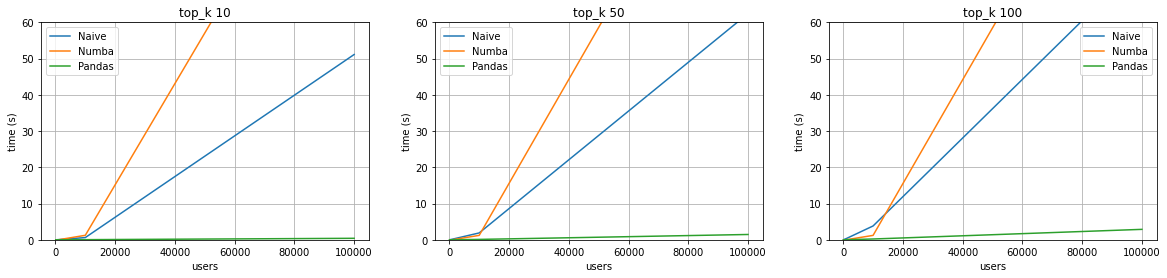

In [35]:
graf, ax = plt.subplots(1,3, figsize=(20,4))
for i in range(3):
  ax[i].plot(users_count, t_naive[:,i], label='Naive')
  ax[i].plot(users_count, t_numba[:,i], label='Numba')
  ax[i].plot(users_count, t_pandas[:,i], label='Pandas')
  ax[i].set_xlabel('users')
  ax[i].set_ylabel('time (s)')
  ax[i].set_title(f'top_k {top_k[i]}')
  ax[i].set_ylim(0, 60)
  ax[i].grid()
  ax[i].legend()
plt.show()

In [36]:
t2_naive = np.array(time_naive).reshape((3, 4))
t2_numba = np.array(time_numba).reshape((3, 4))
t2_pandas = np.array(time_pandas).reshape((3, 4))

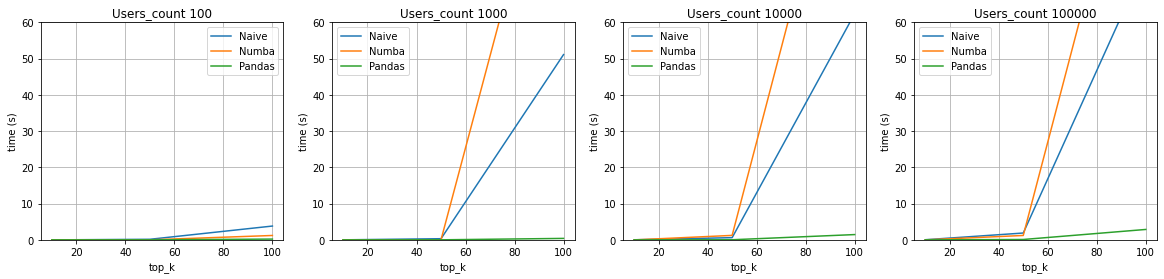

In [45]:
graf, ax = plt.subplots(1, 4, figsize=(20, 4))
for i in range(4):
  ax[i].plot(top_k, t2_naive[:,i], label='Naive')
  ax[i].plot(top_k, t2_numba[:,i], label='Numba')
  ax[i].plot(top_k, t2_pandas[:,i], label='Pandas')
  ax[i].set_xlabel('top_k')
  ax[i].set_ylabel('time (s)')
  ax[i].set_title(f'Users_count {users_count[i]}')
  ax[i].set_ylim(0, 60)
  ax[i].grid()
  ax[i].legend()
plt.show()